In [5]:
import json
from collections import Counter
import pickle
import numpy as np
import pandas as pd
import os
import sys
import argparse
from os.path import dirname, realpath
import math
import hashlib
import datetime
import datetime as datetime
sys.path.append("./src/")

import torch
from torch import nn, optim
from torch.nn import functional as F

from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator
#import plotter
#from plotter import plotter
import matplotlib.pyplot as plt

sys.path.append(dirname(dirname(realpath(os.getcwd()))))

In [6]:
src_path = "G:\\FillmoreCancerData\\markhe\\VTERisk" 
src_path2 = "G:\\FillmoreCancerData\\markhe\\VTERisk - Copy" 

def md5(key):
    return hashlib.md5(repr(key).encode()).hexdigest()
testDF = pd.read_csv(os.path.join(src_path2, 'Notebooks/Find/fixed_dx.csv'))
pat_ids = (testDF['patient_id'] ).astype(int)
testDF['pids'] = pat_ids.apply(md5)

In [7]:
def compute_calibration_curve(golds_for_eval,Probs_for_eval):
    prob_true, prob_pred = calibration_curve(golds_for_eval, Probs_for_eval, n_bins=40)
    return prob_true, prob_pred


In [8]:
def get_4Ms(M):
    M1 = M.drop_duplicates(['patient_id'])
    m0 = M.duplicated(['patient_id'])
    M234 = M[m0]
    M2 = M234.drop_duplicates(['patient_id'])

    m00 = M234.duplicated(['patient_id'])
    M34 = M234[m00]
    M3 = M34.drop_duplicates(['patient_id'])

    m000 = M34.duplicated(['patient_id'])
    M4 = M34[m000]
    return M1, M2, M3, M4

In [9]:
tdf = pd.DataFrame({'patient_id': (testDF['patient_id'] ),    
                    'pids': (testDF['pids'] ),    
                  'dob': (testDF['dob'] ),  
                  'outcome_date': (testDF['outcome_date'] ), 
                  'obs_time_end': (testDF['obs_time_end'] ),  
                  'index_date': (testDF['index_date'] ),  
                  'diag_date': (testDF['diag_date'] ),  
                  'outcome': (testDF['outcome'])    })


In [10]:
#devpath = os.path.join(src_path ,'logs_transformer_vte/K/12_4/', "a8e44cbb2213334954e85de32bdcaf2c.results.dev_preds")
devpath = os.path.join(src_path ,'logs_transformer_vte/K/12_4/', "6a827773e837f2b6ddb9b70a2821c81f.results.dev_preds")
with open(devpath, 'rb') as f:
    R = pickle.load(f)
    p = np.array(R['probs'])
Df = pd.DataFrame.from_dict(R)
Df['probs'] = Df['probs'].astype(float)
Df['exams'] = Df['exams'].astype(int)
M = pd.merge(tdf, Df)
M1, M2, M3, M4 = get_4Ms(M)

In [11]:
#testpath = os.path.join(src_path ,'logs_transformer_vte/K/12_4/', "a8e44cbb2213334954e85de32bdcaf2c.results.test_preds")
testpath = os.path.join(src_path ,'logs_transformer_vte/K/12_4/', "6a827773e837f2b6ddb9b70a2821c81f.results.test_preds")
with open(testpath, 'rb') as f:
    R_t = pickle.load(f)
Df_test = pd.DataFrame.from_dict(R_t)
Df_test['probs'] = Df_test['probs'].astype(float)
M_test = pd.merge(tdf, Df_test)
M_test1, M_test2, M_test3, M_test4 = get_4Ms(M_test)

In [12]:
def logit (p): return np.log(  p / (1 - p) )
def expit (p): return  1/(1 + np.exp(-p))

In [13]:
mp0 = np.array(M['probs'])
mp1 = np.array(M1['probs'])
mp2 = np.array(M2['probs'])
mp3 = np.array(M3['probs'])
mp4 = np.array(M4['probs'])

In [14]:
tp0 = np.array(M_test['probs'])
tp1 = np.array(M_test1['probs'])
tp2 = np.array(M_test2['probs'])
tp3 = np.array(M_test3['probs'])
tp4 = np.array(M_test4['probs'])

In [15]:
gold0 =   np.array(M['golds'],dtype = int)
gold1 =   np.array(M1['golds'],dtype = int)
gold2 =   np.array(M2['golds'],dtype = int)
gold3 =   np.array(M3['golds'],dtype = int)
gold4 =   np.array(M4['golds'],dtype = int)

In [16]:
tgold1 =   np.array(M_test1['golds'],dtype = int)
tgold2 =   np.array(M_test2['golds'],dtype = int)
tgold3 =   np.array(M_test3['golds'],dtype = int)
tgold4 =   np.array(M_test4['golds'],dtype = int)
tgold0 =   np.array(M_test['golds'],dtype = int)

In [17]:
def platt0 (y_prob, y_true, p_test):
    logistic = LogisticRegression(C=1e4, solver='lbfgs', fit_intercept = False)
    y_logit = logit(y_prob) ###
    logistic.fit(y_logit.reshape(-1,1), y_true )
    coef_ = logistic.coef_[0]
    #intercept_ = logistic.intercept_
    fit = logit(p_test) * coef_[0] #+ intercept_
    out = 1 / (1 + np.exp(-fit))
    return  out

In [18]:
def platt (y_prob, y_true, p_test):
    logistic = LogisticRegression(C=1e4, solver='lbfgs')
    y_logit = logit(y_prob) ###
    logistic.fit(y_logit.reshape(-1,1), y_true )
    coef_ = logistic.coef_[0]
    intercept_ = logistic.intercept_
    fit = logit(p_test) * coef_[0] + intercept_
    out = 1 / (1 + np.exp(-fit))
    return  out

In [19]:
global_cal_dev =platt0 (np.array(M['probs']), np.array(M ['golds'],dtype = int),  M ['probs']  )
#global_cal_dev =platt (np.array(M['probs']), np.array(M ['golds'],dtype = int),  M_test ['probs']  )

(array([4.4896e+04, 4.4150e+03, 2.0650e+03, 1.3470e+03, 8.1200e+02,
        4.8000e+02, 2.7100e+02, 1.0200e+02, 3.6000e+01, 7.0000e+00]),
 array([0.00052188, 0.03959418, 0.07866649, 0.11773879, 0.1568111 ,
        0.1958834 , 0.23495571, 0.27402801, 0.31310032, 0.35217263,
        0.39124493]),
 <BarContainer object of 10 artists>)

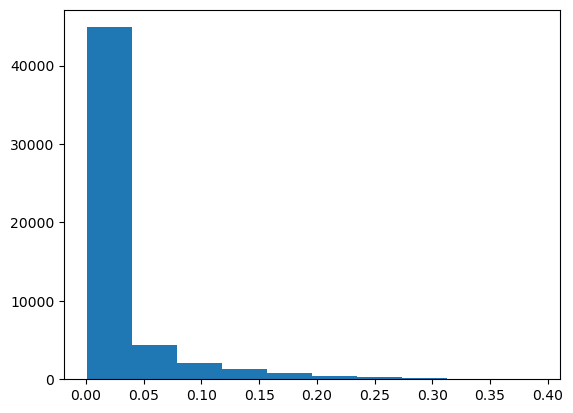

In [20]:
plt.hist(  (global_cal_dev ))

In [21]:
M ['cal'] = global_cal_dev

In [22]:
D_cal1, D_cal2, D_cal3, D_cal4 = get_4Ms(M)
cp1 = np.array(D_cal1['cal'])
cp2 = np.array(D_cal2['cal'])
cp3 = np.array(D_cal3['cal'])
cp4 = np.array(D_cal4['cal'])

(array([8.066e+03, 3.034e+03, 1.965e+03, 1.333e+03, 8.090e+02, 4.780e+02,
        2.700e+02, 1.020e+02, 3.600e+01, 7.000e+00]),
 array([0.00061105, 0.03967444, 0.07873783, 0.11780121, 0.1568646 ,
        0.19592799, 0.23499138, 0.27405477, 0.31311815, 0.35218154,
        0.39124493]),
 <BarContainer object of 10 artists>)

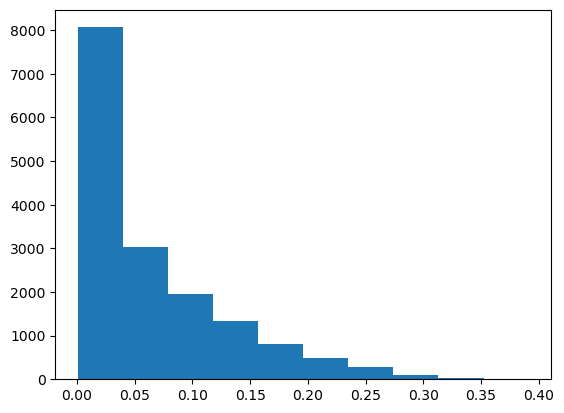

In [23]:
plt.hist(cp1)

In [24]:
f1 =platt (cp1,  np.array(M1['golds'],dtype = int), tp1 )
f2 =platt (cp2,  np.array(M2['golds'],dtype = int),  tp2 )
f3 =platt (cp3,  np.array(M3['golds'],dtype = int),  tp3 )
f4 =platt (cp4,  np.array(M4['golds'],dtype = int), tp4  )

In [25]:
y1, p1 = compute_calibration_curve(M_test1['golds'], f1 )
y2, p2 = compute_calibration_curve(M_test2['golds'], f2 )
y3, p3 = compute_calibration_curve(M_test3['golds'], f3 )
y4, p4 = compute_calibration_curve(M_test4['golds'], f4 )


In [26]:
y0, p0 = compute_calibration_curve(M_test['golds'], cal0 )


NameError: name 'cal0' is not defined

In [ ]:
import matplotlib.pyplot as plt

def plotter (p_i, y_i):
    plt.figure(figsize=(5, 5))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax1.plot(p_i, y_i, 's-')
    ax1.plot([0, 1], [0, 1], linestyle='--', 
             color='grey', label='random guess (AUROC: 0.500)')
    ax2.hist(p_i, bins=10, range=(0, 1))
    ax1.set_xlim([-0.01, 1.01])
    ax1.set_ylim([-0.01, 1.01])
    ax1.set_xlabel('Predicted value')
    ax1.set_ylabel('Fraction of positive')
    ax1.set_title("Calibration plot")
    ax2.set_xlabel('Prediction probability')
    ax2.set_ylabel('Count')
    plt.tight_layout()
    

In [ ]:
plotter(p0, y0)

In [ ]:
y00, p00 = compute_calibration_curve(M_test['golds'], tp0 )

plotter(p00, y00)

In [ ]:
plotter(p1, y1)

In [ ]:
plotter(p2, y2)

In [ ]:
plotter(p3, y3)

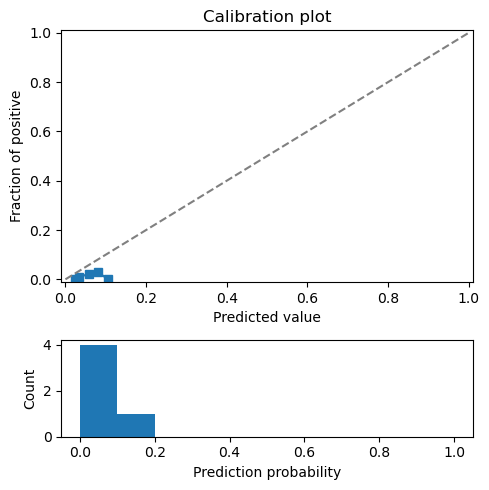

In [65]:
plotter(p4, y4)

In [120]:
# how many people had event within 6 months of index date

In [121]:
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_auc_score

In [103]:
tgold


array([0, 0, 0, ..., 0, 0, 0])

In [104]:
roc_auc_score(tgold, tp0, average = 'samples')


0.7041921073688241

In [105]:
roc_auc_score(tgold1, tp1, average = 'samples')


0.6467984051574288

In [106]:
roc_auc_score(tgold2, tp2, average = 'samples')


0.6168729524353275

In [107]:
roc_auc_score(tgold3, tp3, average = 'samples')


0.6673084299413196

In [108]:
roc_auc_score(tgold4, tp4, average = 'samples')


0.6831130697591268

In [136]:
np.mean(tgold)**.5

0.1324351605094734

In [146]:
( confusion_matrix (tgold  , cal0>.05) )

array([[51384,  2615],
       [  802,   162]], dtype=int64)

In [109]:
( confusion_matrix (tgold4  , cal4>.5) )

array([[11363,   263],
       [   95,     7]], dtype=int64)

In [110]:
( confusion_matrix (tgold3 , cal3>.5) )

array([[12448,   302],
       [  132,     5]], dtype=int64)

In [111]:
( confusion_matrix (tgold2 , cal2>.5) )

array([[13952,    60],
       [  208,     2]], dtype=int64)

In [112]:
( confusion_matrix (tgold1, cal1>.5) )

array([[15070,   541],
       [  479,    36]], dtype=int64)

In [87]:
def get_coef (y_prob, y_true, p_test):
    logistic = LogisticRegression(C=1e4, solver='lbfgs')
    logistic.fit(y_prob.reshape(-1,1), y_true)
    coef_ = logistic.coef_[0]
    intercept_ = logistic.intercept_
    fit = p_test * coef_[0] + intercept_
    return  coef_ , intercept_

In [ ]:
m1.to_csv('output/XCoh_Sen.csv') 

In [34]:
#m1.to_excel('output/dxMD_Sensitivity90.xlsx') 